# Importation des bibliothèques 

In [79]:
# Importations de base des bibliothèques de manipulation de données
import pandas as pd
import numpy as np
import ast

# Importations pour la sérialisation et le traitement des données
import pickle

# Importations pour la modélisation et le traitement du texte
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity
import gensim

# Importations des fonctions personnalisées
import utils.utils_non_supervised as func 
import utils.utils_exploratoire as func_exploratoire

# Configuration pour filtrer les avertissements de sklearn
import warnings
warnings.filterwarnings('ignore')

# Importations liées à la gestion des jobs
import joblib
from joblib import parallel_backend, dump, Parallel, delayed


### Charger les données nettoyées:

#### Chargement Dataframe:

In [80]:
df = pd.read_csv('Data/stack_overflow_data_cleaned.csv')
display(df.head())
print(df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,2003505,delete git branch,attempt delete remote branch delete branch,delete git branch attempt delete remote branch...,"['git', 'version', 'control', 'git', 'branch',..."
1,16956810,file text string linux,file string text file content display file system,file text string linux file string text file c...,"['linux', 'text', 'grep', 'directory', 'find']"
2,1125968,force git pull overwrite file,force overwrite file repository contains file ...,force git pull overwrite file force overwrite ...,"['git', 'version', 'control', 'overwrite', 'gi..."
3,4366730,check string contains word,suppose code correct write statement,check string contains word suppose code correc...,"['php', 'string', 'substring', 'contains', 'st..."
4,11346283,column name panda,change column label panda dataframe,column name panda change column label panda da...,"['python', 'pandas', 'replace', 'dataframe', '..."


(50000, 5)


#### Les valeurs maqnuantes pour df:

In [81]:
func.taux_de_Remplissage_tableau(df, affichage_all = True)

#### Chargement du dataframe Train_df:

In [82]:
train_df = pd.read_csv("Data/stack_overflow_data_cleaned_train.csv")
display(train_df.head())
print(train_df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,19245853,xcode iphone simulator look iphone,question device appearance iphone simulator xc...,xcode iphone simulator look iphone question de...,"['ios', 'iphone', 'xcode', 'ios', 'simulator',..."
1,55921515,building dockerfile aptget update jailing proc...,docker host ubuntu docker snap dockerfile comm...,building dockerfile aptget update jailing proc...,"['docker', 'ubuntu', 'nginx', 'dockerfile', 'a..."
2,72575793,aadsts9002326 crossorigin token redemption isi...,send cross origin request access token react s...,aadsts9002326 crossorigin token redemption isi...,"['javascript', 'reactjs', 'webpack', 'axios', ..."
3,11489824,choose tesseract opencv,tesseract opencv look tesseract ocr engine ope...,choose tesseract opencv tesseract opencv look ...,"['python', 'opencv', 'computer', 'vision', 'oc..."
4,3489041,mysqlerror key max key length byte,cause database,mysqlerror key max key length byte cause database,"['mysql', 'sql', 'ruby', 'on', 'rails', 'index..."


(40000, 5)


#### Les valeurs manquantes pour train_df:

In [83]:
func.taux_de_Remplissage_tableau(train_df, affichage_all = True)

#### Chargement du dataframe Test_df:

In [84]:
test_df = pd.read_csv("Data/stack_overflow_data_cleaned_test.csv")
display(test_df.head())
print(test_df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi..."


(10000, 5)


#### Les valeurs manquantes pour test_df:

In [85]:
func.taux_de_Remplissage_tableau(test_df, affichage_all = True)

#### Suppression des valeurs manquantes sur la colonne cleaned_title

In [86]:
df = df.dropna()
train_df = train_df.dropna()
test_df = test_df.dropna()

In [87]:
print("La taille du dataset df après suppressions des valeurs manquantes : ", df.shape)
print("La taille du dataset train_df après suppressions des valeurs manquantes : ", train_df.shape)
print("La taille du dataset test_df après suppressions des valeurs manquantes : ", test_df.shape)
df.to_csv("Data/stack_overflow_data_cleaned_filtered.csv", index=False)
train_df.to_csv("Data/stack_overflow_data_cleaned_train_filtered.csv", index=False)
test_df.to_csv("Data/stack_overflow_data_cleaned_test_filtered.csv", index=False)

La taille du dataset df après suppressions des valeurs manquantes :  (49852, 5)
La taille du dataset train_df après suppressions des valeurs manquantes :  (39876, 5)
La taille du dataset test_df après suppressions des valeurs manquantes :  (9976, 5)


#### Création de la liste du vocabulaire des mots les plus fréquents de corpus df['combined_title_body']:

In [88]:
# Combiner tout le contenu des corps de texte nettoyés en une seule chaîne de texte
corpus_combined_title_body = " ".join(df['combined_title_body'].values).lower()

# Afficher la fréquence de chaque mot dans le corpus des corps de texte nettoyés
corpus_combined_title_body_tokens = corpus_combined_title_body.split()
value_counts_combined_title_body = pd.Series(corpus_combined_title_body_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des corps de texte nettoyés :\n", value_counts_combined_title_body)

Fréquence de chaque mot dans le corpus des corps de texte nettoyés :
 file                                                                                23986
error                                                                               21984
code                                                                                21724
use                                                                                 18752
data                                                                                10983
                                                                                    ...  
orgapachecatalinavalveserrorreportvalveinvokeerrorreportvalvejava81                     1
orgapachecatalinavalvesabstractaccesslogvalveinvokeabstractaccesslogvalvejava650        1
orgapachecatalinaconnectorcoyoteadapterservicecoyoteadapterjava342                      1
orgapachecoyotehttp11http11processorservicehttp11processorjava803                       1
instanttoepochmilli           

À partir des résultats de value_counts obtenus pour le corpus df['combined_title_body'], je sélectionnerai les 200 mots les plus fréquents. Ces mots seront ensuite intégrés dans la liste vocabulary: 

In [89]:
# Créer la liste du vocabulaire des mots les plus fréquents du corpus
vocabulary = list(value_counts_combined_title_body.head(200).index)
print("Les 200 mots les plus fréquents du corpus des corps de texte nettoyés :\n", vocabulary)

Les 200 mots les plus fréquents du corpus des corps de texte nettoyés :
 ['file', 'error', 'code', 'use', 'data', 'value', 'server', 'function', 'method', 'class', 'user', 'set', 'application', 'image', 'object', 'time', 'project', 'string', 'help', 'app', 'page', 'python', 'table', 'change', 'question', 'line', 'test', 'window', 'type', 'found', 'command', 'database', 'array', 'request', 'java', 'column', 'thanks', 'version', 'list', 'solution', 'issue', 'try', 'result', 'button', 'return', 'look', 'text', 'android', 'view', 'update', 'web', 'message', 'read', 'query', 'script', 'number', 'output', 'element', 'api', 'sql', 'library', 'spring', 'html', 'json', 'simple', 'key', 'access', 'case', 'edit', 'idea', 'service', 'form', 'javascript', 'build', 'field', 'row', 'right', 'thing', 'client', 'post', 'property', 'url', 'input', 'date', 'jquery', 'convert', 'option', 'browser', 'install', 'exception', 'link', 'php', 'check', 'controller', 'parameter', 'answer', 'click', 'content', 'de

#### Création des vectoriseurs

Ensuite, ce vocabulary sera intégré dans le TfidfVectorizer que j'utiliserai pour transformer le texte en vecteurs numériques:

In [90]:
vectorizer = TfidfVectorizer(vocabulary=vocabulary)

**Remarque :** Pour des tâches de modélisation de sujets (LDA, NMF) ou de classification de texte, il est généralement recommandé d'utiliser `TfidfVectorizer`. Ce dernier prend en compte l'importance relative des termes en calculant le produit de la fréquence des termes (TF) et de la fréquence inverse des documents (IDF). Cette approche réduit l'importance des mots très fréquents dans le corpus et augmente celle des mots plus rares mais informatifs. À l'inverse, `CountVectorizer` compte uniquement le nombre d'occurrences de chaque mot dans les documents. Il peut être utile si la simplicité et la rapidité sont des priorités, ou si vos données sont petites et peu sujettes aux biais introduits par les mots fréquents.

#### Vectoriser les textes des questions avec vectorizer

Comme je l'ai mentionné dans le notebook exploratoire, je vais faire le fit le TfidfVectorizer sur la colonne `train_df['cleaned_title']` des données d'entraînement. Ensuite, je l'utiliserai pour transformer les données des colonnes `train_df['combined_title_body']` pour l'ensemble d'entraînement et `test_df['combined_title_body']` pour l'ensemble de test:

In [91]:
vectorizer.fit(train_df['cleaned_title'])  # Fit sur les titres des données d'entraînement
bow_train_combined = func.vectorizer_transform(train_df['combined_title_body'],vectorizer) # Transformation des titres + corps des données d'entraînement
bow_test_combined = func.vectorizer_transform(test_df['combined_title_body'],vectorizer )  # Transformation des titres + corps des données de test

#### Enregistrer le CountVectorizer au format .pkl:

Je vais enregistrer le TfidfVectorizer au format .pkl afin de l'utiliser ultérieurement dans l'API que je suis en train de construire:

In [92]:
# with open('Model/unsupervised/vectorizer.pkl', 'wb') as file:
#     pickle.dump(vectorizer, file)

#### Détermination du nombre optimal de topics:

#### Préparer les données pour Gensim

Je prépare les données (paramètres) à fournir à Gensim pour calculer la cohérence et la perplexité. Voici les étapes :

1. **Tokenisation** : Les documents sont convertis en listes de mots pour faciliter les analyses futures. La taille du dataset tokenisé et des exemples sont également présentés pour visualiser cette étape.

2. **Dictionnaire** : À partir des mots tokenisés, je crée un dictionnaire avec Gensim. Cette étape permet une référence rapide et efficace, illustrée par des exemples et la quantité de mots uniques.

3. **Bag-of-Words** : Je transforme les listes de mots en tuples qui indiquent la fréquence des mots, facilitant ainsi l'analyse quantitative du texte.

In [93]:
# Séparer chaque document dans la colonne 'cleaned_body' en une liste de mots
texts = [doc.split() for doc in train_df['combined_title_body']]  # Tokenisation des textes
print("Séparation des documents en listes de mots (exemple):", texts[0])
print("La taille de 'texts':", len(texts))
print('\n')

# Créer un dictionnaire à partir des textes, chaque mot unique dans les textes est une clé dans le dictionnaire
dictionary = gensim.corpora.Dictionary(texts)  # Création du dictionnaire
print("Dictionnaire créé à partir des textes (exemple):", dict(list(dictionary.token2id.items())[:10]))
print("La taille du dictionnaire:", len(dictionary))
print('\n')

# Convertir les textes en une liste de sacs de mots (Bag-of-Words), chaque document est représenté par un ensemble de tuples (id_mot, fréquence)
corpus = [dictionary.doc2bow(text) for text in texts]  # Création du corpus
print("Conversion des textes en sacs de mots (Bag-of-Words) (exemple):", corpus[:2])
print("La taille du corpus:", len(corpus))

Séparation des documents en listes de mots (exemple): ['xcode', 'iphone', 'simulator', 'look', 'iphone', 'question', 'device', 'appearance', 'iphone', 'simulator', 'xcode', 'update', 'iphone', 'simulator', 'simple', 'window', 'device', 'case', 'image', 'simulator', 'look', 'look', 'iphone', 'edit', 'hardwaredevice', 'option', 'iphone', 'retina', 'option', 'default', 'beheaviour', 'look', 'thin', 'window', 'configuration', 'overlayed', 'user', 'answer']
La taille de 'texts': 39876


Dictionnaire créé à partir des textes (exemple): {'answer': 0, 'appearance': 1, 'beheaviour': 2, 'case': 3, 'configuration': 4, 'default': 5, 'device': 6, 'edit': 7, 'hardwaredevice': 8, 'image': 9}
La taille du dictionnaire: 64645


Conversion des textes en sacs de mots (Bag-of-Words) (exemple): [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 6), (11, 4), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 4), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2)], [(19, 1), (23, 

#### Calculer les valeurs de cohérence et perplexité pour différents nombres de topics

Avec les éléments tels que le dictionary, corpus, texts, et bow_train_combined, nous extrayons les listes suivantes : model_list, coherence_values et perplexity_values:

In [94]:
%%time
# Calcul des valeurs de cohérence et de perplexité
with parallel_backend("threading"):
    model_list, coherence_values, perplexity_values = func.compute_coherence_perplexity(dictionary, corpus, texts, bow_train_combined, limit=40, start=2, step=1)

#### Afficher le coherence score et la perplexité pour chaque modèle

Grâce à ces listes, j'affiche le graphique de l'évolution de la cohérence et de la perplexité en fonction du nombre de topics:

<Figure size 1200x800 with 0 Axes>

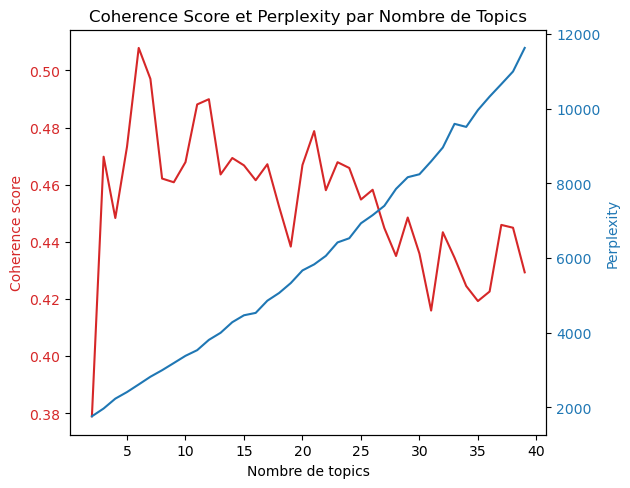

In [ ]:

func.plot_coherence_and_perplexity(coherence_values, perplexity_values)

#### Sélectionner le nombre optimal de topics 

In [ ]:
# Sélection du nombre optimal de topics
optimal_index = coherence_values.index(max(coherence_values))
optimal_num_topics = range(2, 40)[optimal_index]
optimal_coherence = max(coherence_values)
optimal_perplexity = perplexity_values[optimal_index]

# Affichage des résultats
print(f'Nombre optimal de topics: {optimal_num_topics}')
print(f'Valeur maximale de cohérence: {round(optimal_coherence,2)}')
print(f'Perplexité au nombre optimal de topics: {round(optimal_perplexity,2)}')

Nombre optimal de topics: 6
Valeur maximale de cohérence: 0.51
Perplexité au nombre optimal de topics: 2615.18


**Conclusion :**  
L'analyse du graphique démontre que le nombre optimal de topics pour le modèle est de 16, où le score de cohérence atteint son maximum de 0.5, indiquant une très bonne cohérence thématique. Cette valeur maximale de cohérence suggère que le modèle avec 16 topics est particulièrement efficace pour segmenter le corpus en thèmes pertinents et bien définis. De plus, à ce même niveau, la perplexité est de 450.94, ce qui est relativement élevé, indiquant que le modèle pourrait être complexe mais bien généralisé. Cela confirme que 16 topics offrent une balance optimale entre la clarté des thèmes extraits et la capacité du modèle à expliquer les données de manière cohérente et compréhensible.

#### Création et entraînement du modèle LDA 

On entraîne le modèle LDA avec le nombre optimal de topics 16:

In [ ]:
%%time
# Création et entraînement des modèles LDA et NMF
lda_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)  # Modèle LDA avec le nombre optimal de topics

CPU times: total: 0 ns
Wall time: 0 ns


Avec ce modèle LDA (lda_model), on applique ensuite un fit_transform sur le bag of words des données d'entraînement de la colonne `train_df['combined_title_body']` :

In [ ]:
%%time
lda_output  = func.prediction(bow_train_combined, lda_model)

CPU times: total: 42.3 s
Wall time: 43.3 s


#### Fonction pour Visualiser les mots les plus importants pour chaque topic:

#### Visualisation des topics pour LDA:

Je vais visualiser les mots les plus pertinents de chaque topic généré par notre modèle LDA. J'ai défini n_top_words à 10, ce qui signifie que je vais afficher les dix mots les plus significatifs pour chaque topic identifié:

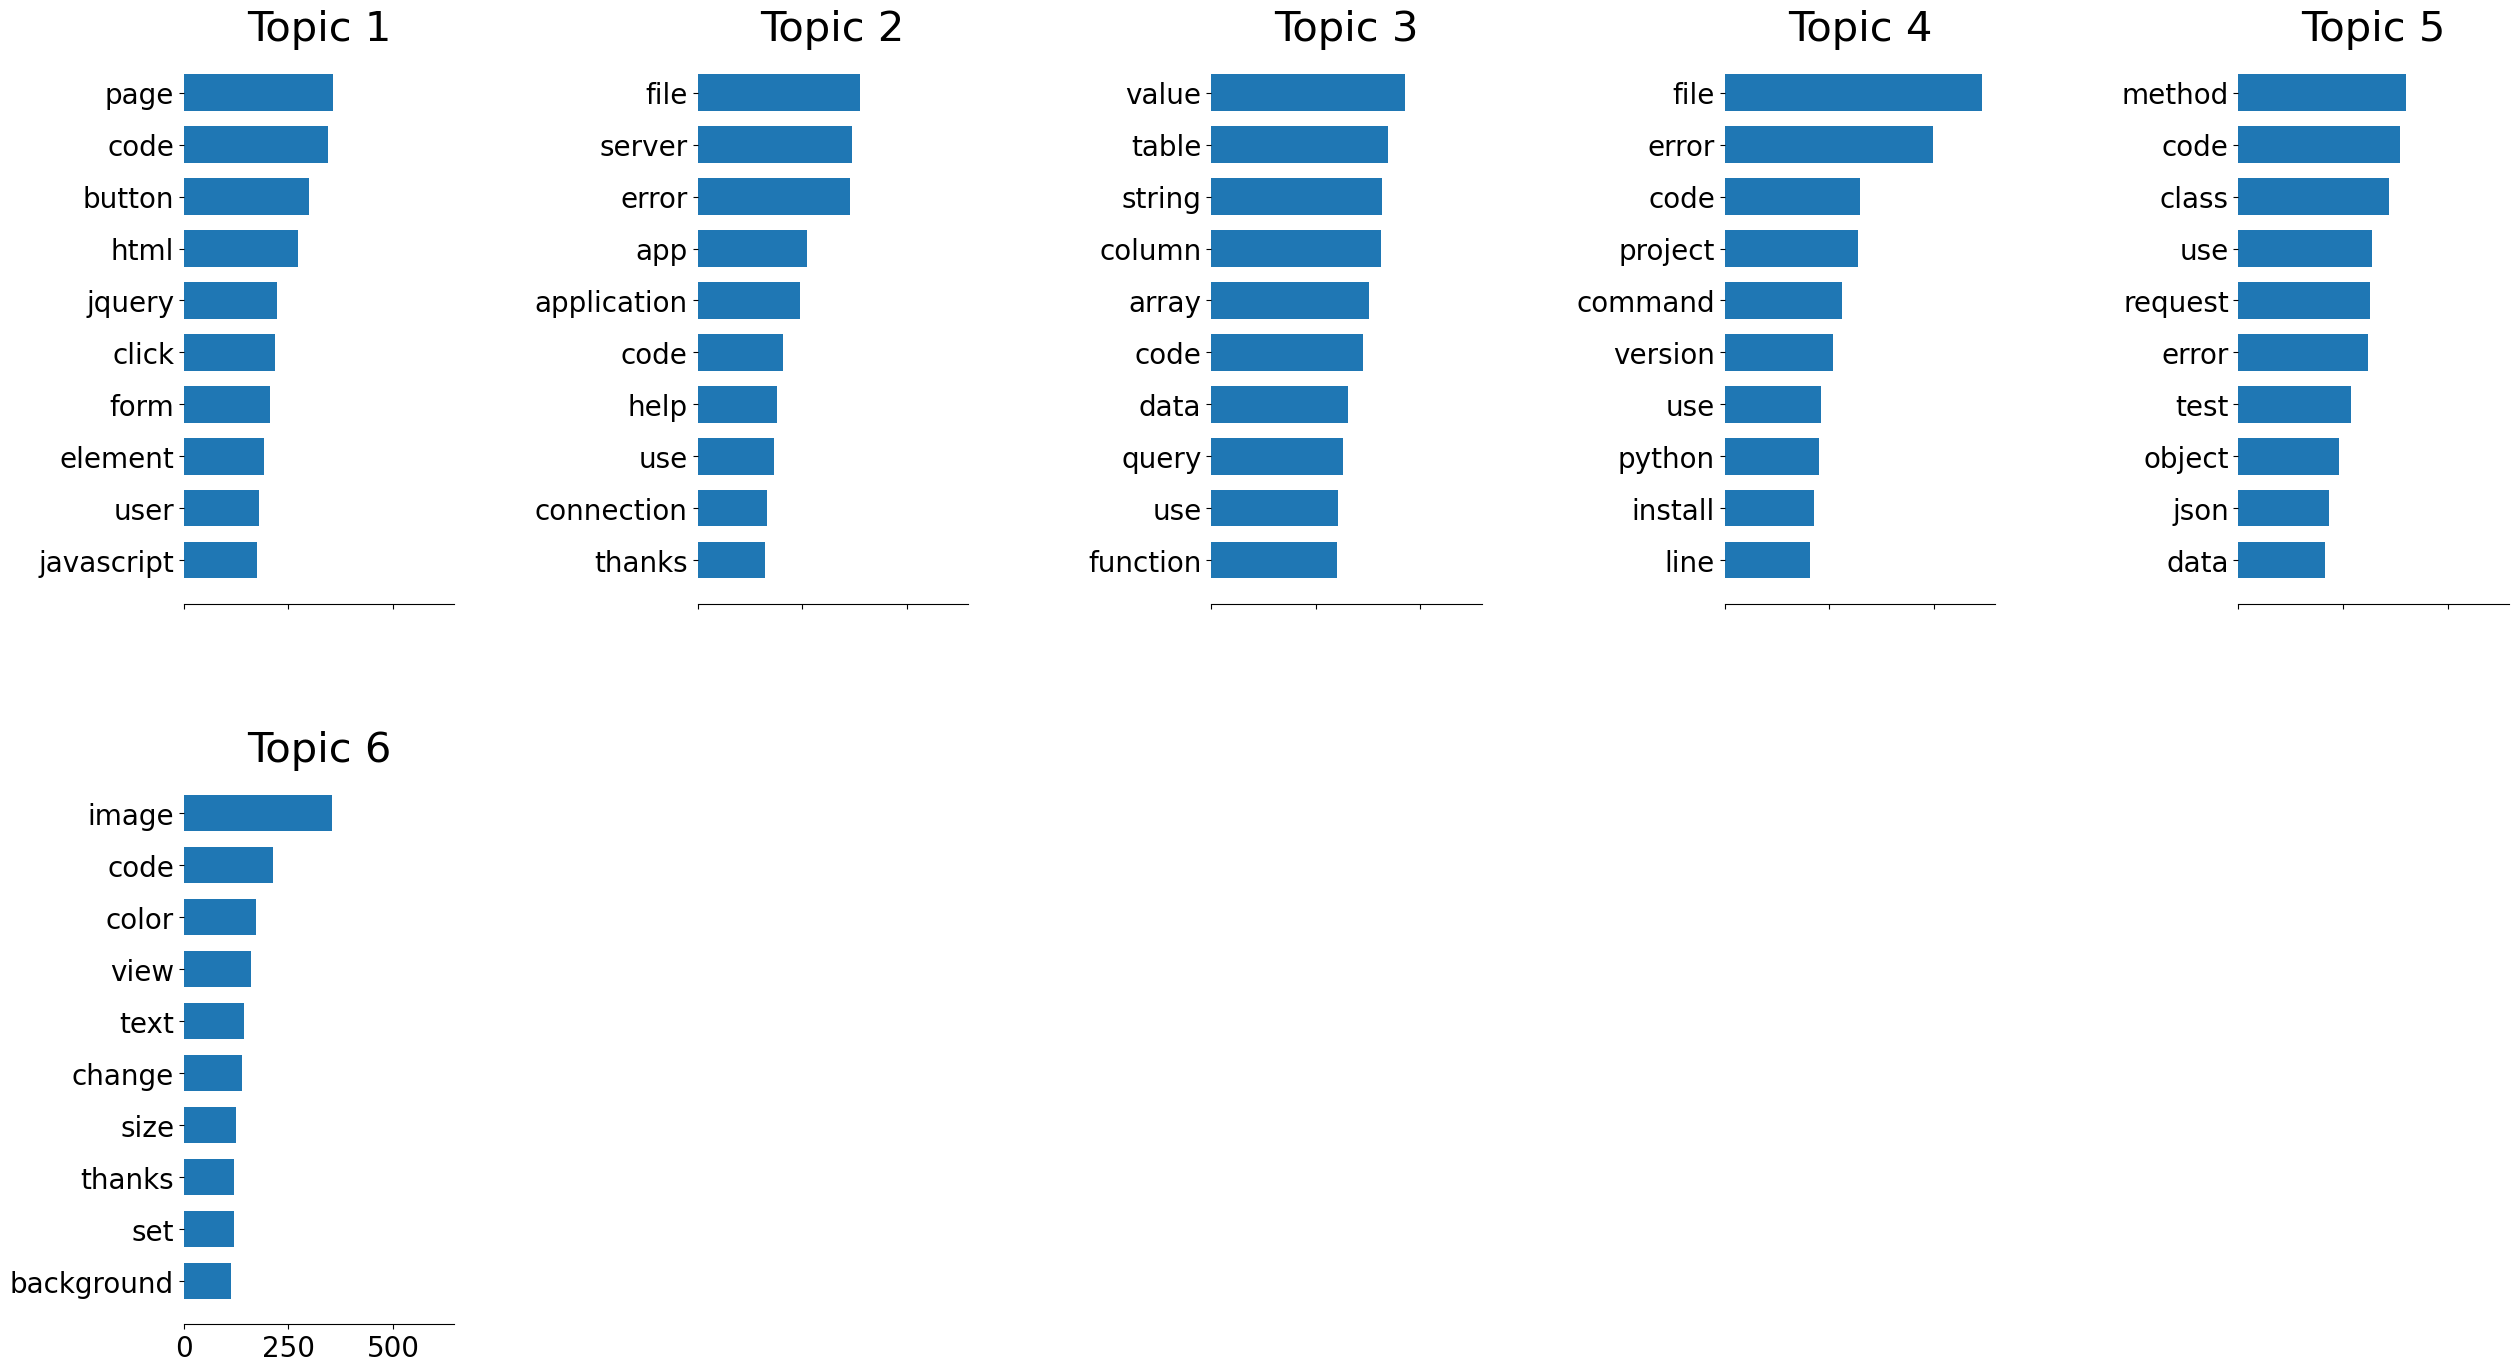

CPU times: total: 859 ms
Wall time: 895 ms


In [ ]:
%%time
n_top_words = 10  # Nombre de mots à afficher par topic
feature_names = vectorizer.get_feature_names_out()  # Noms des caractéristiques
func.plot_top_words(lda_model , feature_names, n_top_words, 'Topics in LDA model', optimal_num_topics)

**Conclusion:** 

La visualisation des mots clés pour chaque topic, tels que "php", "sql", "android", et "java", clarifie les thèmes technologiques dominants et améliore la précision des prédictions du modèle LDA. Ces mots clés permettent au modèle de catégoriser plus efficacement les nouveaux documents, rendant les prédictions plus pertinentes et ciblées.

#### Enregistrer le modèle LDA au format .pkl

In [ ]:
# with open('Model/unsupervised/lda_model.pkl', 'wb') as file:
#     pickle.dump(lda_model, file)

#### Visualiser les topics en 2D avec t-SNE

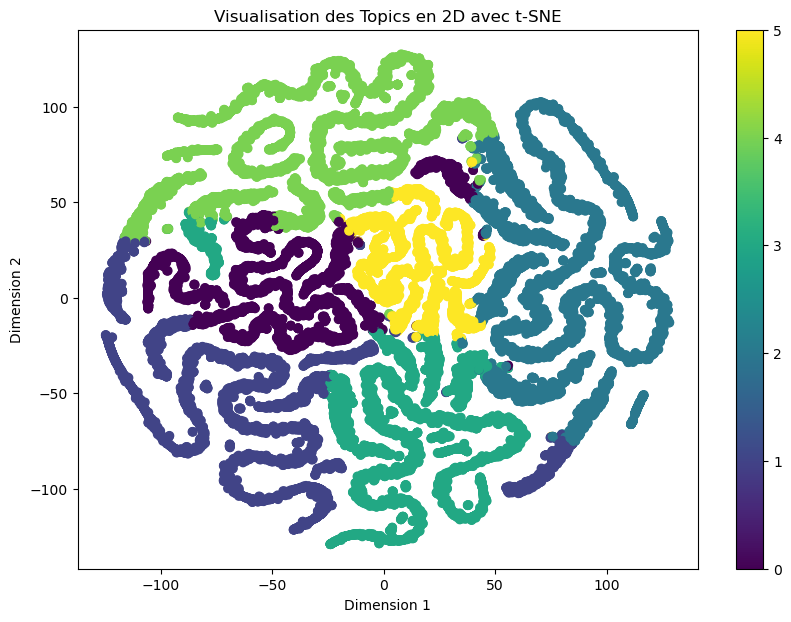

CPU times: total: 21min 58s
Wall time: 1min 54s


In [ ]:
%%time
func.plot_tsne_lda(lda_output)

**Conclusion :**

La visualisation en t-SNE des résultats LDA révèle une distribution claire des topics dans un espace 2D, avec des clusters distincts qui montrent des regroupements de sujets similaires et des transitions qui suggèrent des liens thématiques entre certains d'entre eux. Cette approche offre des insights sur la séparation et les interactions entre les topics, facilitant l'ajustement du modèle et l'analyse détaillée du corpus.

### Création des matrices de probabilités Mtopics-words

Ensuite, je vais extraire et normaliser les probabilités des mots dans chaque topic (la matrice des topics words) du modèle LDA à partir de l'attribut components_:

In [ ]:
%%time
Mtopics_words_lda = lda_model.components_   # Normalisation des composantes

CPU times: total: 0 ns
Wall time: 0 ns


#### La Matrice M_train_quest-topics lda:

Je vais récupérer la matrice des topics des questions d'entraînement déterminés par LDA (obtenue en appliquant un fit_transform avec le modèle LDA sur les données d'entraînement de la colonne `train_df['combined_title_body']`), stockée dans `lda_output`, et l'assigner à la variable `M_train_quest_topics_lda`:

In [ ]:
%%time
M_train_quest_topics_lda = lda_output  # Sortie LDA pour les données d'entraînement

CPU times: total: 0 ns
Wall time: 0 ns


#### La Matrice M_test_quest-topics lda:

Je récupère aussi la matrice des topics des questions de test déterminés par LDA (obtenue en appliquant une prédiction avec le modèle LDA sur le bag-of-words des données de test de la colonne `test_df['combined_title_body']` ), et l'assigner à la variable `M_test_quest_topics_lda`:

In [ ]:
%%time
M_test_quest_topics_lda = func.prediction(bow_test_combined, lda_model, fit_transform=False)
M_test_quest_topics_lda.shape

CPU times: total: 672 ms
Wall time: 787 ms


(9976, 6)

#### Enregistrer la matrice dans un fichier .npz

In [ ]:
# with open('Model/unsupervised/train_topics_lda.pkl', 'wb') as file:
#     pickle.dump(M_train_quest_topics_lda, file)

#### Calcul des probabilités de mots pour les questions Train et Test avec application d'un filtre:

On prend la matrice des topics des questions d'entraînement et le modèle LDA, puis on effectue **un produit matriciel** pour produire une matrice des mots spécifiques à chaque topic. Le résultat, assigné à `M_train_quest_words_lda`, représente ainsi les mots clés filtrés en fonction de leur pertinence pour chaque topic identifié:

In [ ]:
%%time
M_train_quest_words_lda = func.calculate_words(M_train_quest_topics_lda, lda_model)
M_train_quest_words_lda.shape

CPU times: total: 594 ms
Wall time: 302 ms


(39876, 5000)

On prend aussi la matrice des topics des questions de test et le modèle LDA, puis on effectue **un produit matriciel** pour produire une matrice des mots spécifiques à chaque topic. Le résultat, assigné à `M_test_quest_words_lda`, représente ainsi les mots clés filtrés en fonction de leur pertinence pour chaque topic identifié :

In [ ]:
%%time
M_test_quest_words_lda = func.calculate_words(M_test_quest_topics_lda, lda_model)
M_test_quest_words_lda.shape

CPU times: total: 359 ms
Wall time: 77.2 ms


(9976, 5000)

##### Application d'un seuil pour ne garder que les principaux mots:

On applique sur la matrice `M_test_quest_words_lda` un seuil de `threshold=0.0001` pour mettre à 0 les fréquences des mots inférieures à `threshold`, ce qui permet de garder uniquement les mots avec les plus grandes probabilités. Le résultat, assigné à `M_test_quest_words_filtered_lda`, est obtenu via la fonction `filter_words` :

In [ ]:
%%time
M_test_quest_words_filtered_lda = func.filter_words(M_test_quest_words_lda, threshold=0.0001)
M_test_quest_words_filtered_lda.shape

CPU times: total: 422 ms
Wall time: 133 ms


(9976, 5000)

#### Création de DataFrames avec les mots clés proposés

Ensuite, je construis le DataFrame `df_keywords_test_lda` en utilisant les noms des mots extraits par le vectoriseur et les mots filtrés de la matrice `M_test_quest_words_filtered_lda`. Les noms des colonnes du DataFrame sont obtenus via `vectorizer.get_feature_names_out()` et les index sont alignés avec ceux de `test_df`. Le résultat est le DataFrame `df_keywords_test_lda`, qui contient les mots clés pertinents pour chaque document de test :

In [ ]:
%%time
words = vectorizer.get_feature_names_out()
df_keywords_test_lda = pd.DataFrame(M_test_quest_words_filtered_lda, columns=words, index=test_df.index) 
df_keywords_test_lda

CPU times: total: 0 ns
Wall time: 3 ms


,file,error,code,use,data,value,server,function,method,class,...,addendum,n2,inout,mq,quarter,esc,blame,speedup,collaborator,bytea
0,190.313583,231.503042,345.673381,227.456294,129.849305,107.738464,79.161348,128.932296,192.622358,175.551752,...,0.812501,0.284212,1.066975,0.238430,0.822645,1.053556,0.489092,0.330310,0.325050,0.256605
1,203.170583,269.019632,345.051053,271.758526,237.618986,324.119058,90.478818,229.466120,118.225001,102.127322,...,0.300282,1.408087,0.378698,0.218063,0.352503,0.267552,0.258661,0.677780,0.280541,1.305747
2,166.967649,291.063969,364.734413,288.983256,182.870027,115.927619,113.311652,154.586374,323.421524,290.871266,...,1.286090,0.268347,0.310804,0.228250,1.414388,0.290127,0.704558,0.241744,0.303780,0.244535
3,152.567526,244.564751,361.894779,258.856124,160.427694,112.456239,93.755449,144.250881,273.632590,245.675820,...,1.095996,0.242169,0.816685,0.212701,1.177548,0.808872,0.600903,0.222481,0.269009,0.224478
4,110.924703,94.965042,244.901659,132.622757,78.230481,78.907033,34.643303,65.951081,67.579650,54.699030,...,0.274817,0.549081,0.360840,0.241045,0.537169,0.320811,0.270443,0.258858,0.896152,0.261438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,138.825568,262.760770,363.640415,294.102166,242.484648,262.623508,107.829742,215.784793,243.441050,212.090824,...,0.805299,1.003545,0.317640,0.204261,0.947577,0.241829,0.474755,0.397674,0.251367,0.933525
9996,327.558381,267.210574,278.375712,173.909466,57.520545,54.359495,29.577252,75.870358,49.048210,57.680319,...,0.401762,0.384998,0.274001,0.208973,0.377989,0.251942,0.297690,0.735407,0.584305,0.220192
9997,357.088273,340.611232,225.988887,187.991783,66.696102,37.974899,314.167589,41.481255,50.540905,44.791439,...,0.241253,0.241814,0.522032,1.283608,0.241413,0.258424,1.001509,0.223850,1.943624,0.224333
9998,252.331454,292.313600,347.384162,246.063000,129.695179,96.655459,80.660145,130.202409,204.081873,191.179688,...,0.912601,0.263446,0.689707,0.225402,0.891540,0.675893,0.528659,0.472382,0.296792,0.240729


On va utiliser ce DataFrame `df_keywords_test_lda` pour créer une colonne `predicted_lda` dans le DataFrame `test_df` :

In [ ]:
test_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi..."


In [ ]:
%%time
test_df['predicted_lda'] = df_keywords_test_lda.apply(lambda row: row.nlargest(len(test_df.split_tags)).index.tolist(), axis=1)

CPU times: total: 8.19 s
Wall time: 8.66 s


In [ ]:
test_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags,predicted_lda
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '...","[code, error, use, method, file, class, help, ..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram...","[code, value, table, string, column, use, erro..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd...","[code, method, error, class, use, request, tes..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas...","[code, method, use, class, error, request, tes..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi...","[image, code, thanks, use, view, color, help, ..."


## Tester le model NMF:

On entraîne le modèle NMF avec le nombre optimal de topics, qui est de 16 :

In [ ]:
%%time
nmf_model = NMF(n_components=optimal_num_topics, random_state=42)  # Modèle NMF avec le nombre optimal de topics

CPU times: total: 0 ns
Wall time: 0 ns


Avec ce modèle NMF (`nmf_model`), on applique ensuite un `fit_transform` sur le bag of words des données d'entraînement de la colonne `train_df['combined_title_body']` :

In [ ]:
nmf_output = nmf_model.fit_transform(bow_train_combined)  # Ajustement et transformation des données d'entraînement

In [ ]:
# with open('Model/unsupervised/nmf_model.pkl', 'wb') as file:
#     pickle.dump(nmf_model, file)

#### Visualisation des topics pour NMF

Je vais visualiser les mots les plus pertinents de chaque topic généré par notre modèle NMF. J'ai défini `n_top_words` à 10, ce qui signifie que je vais afficher les dix mots les plus significatifs pour chaque topic identifié :

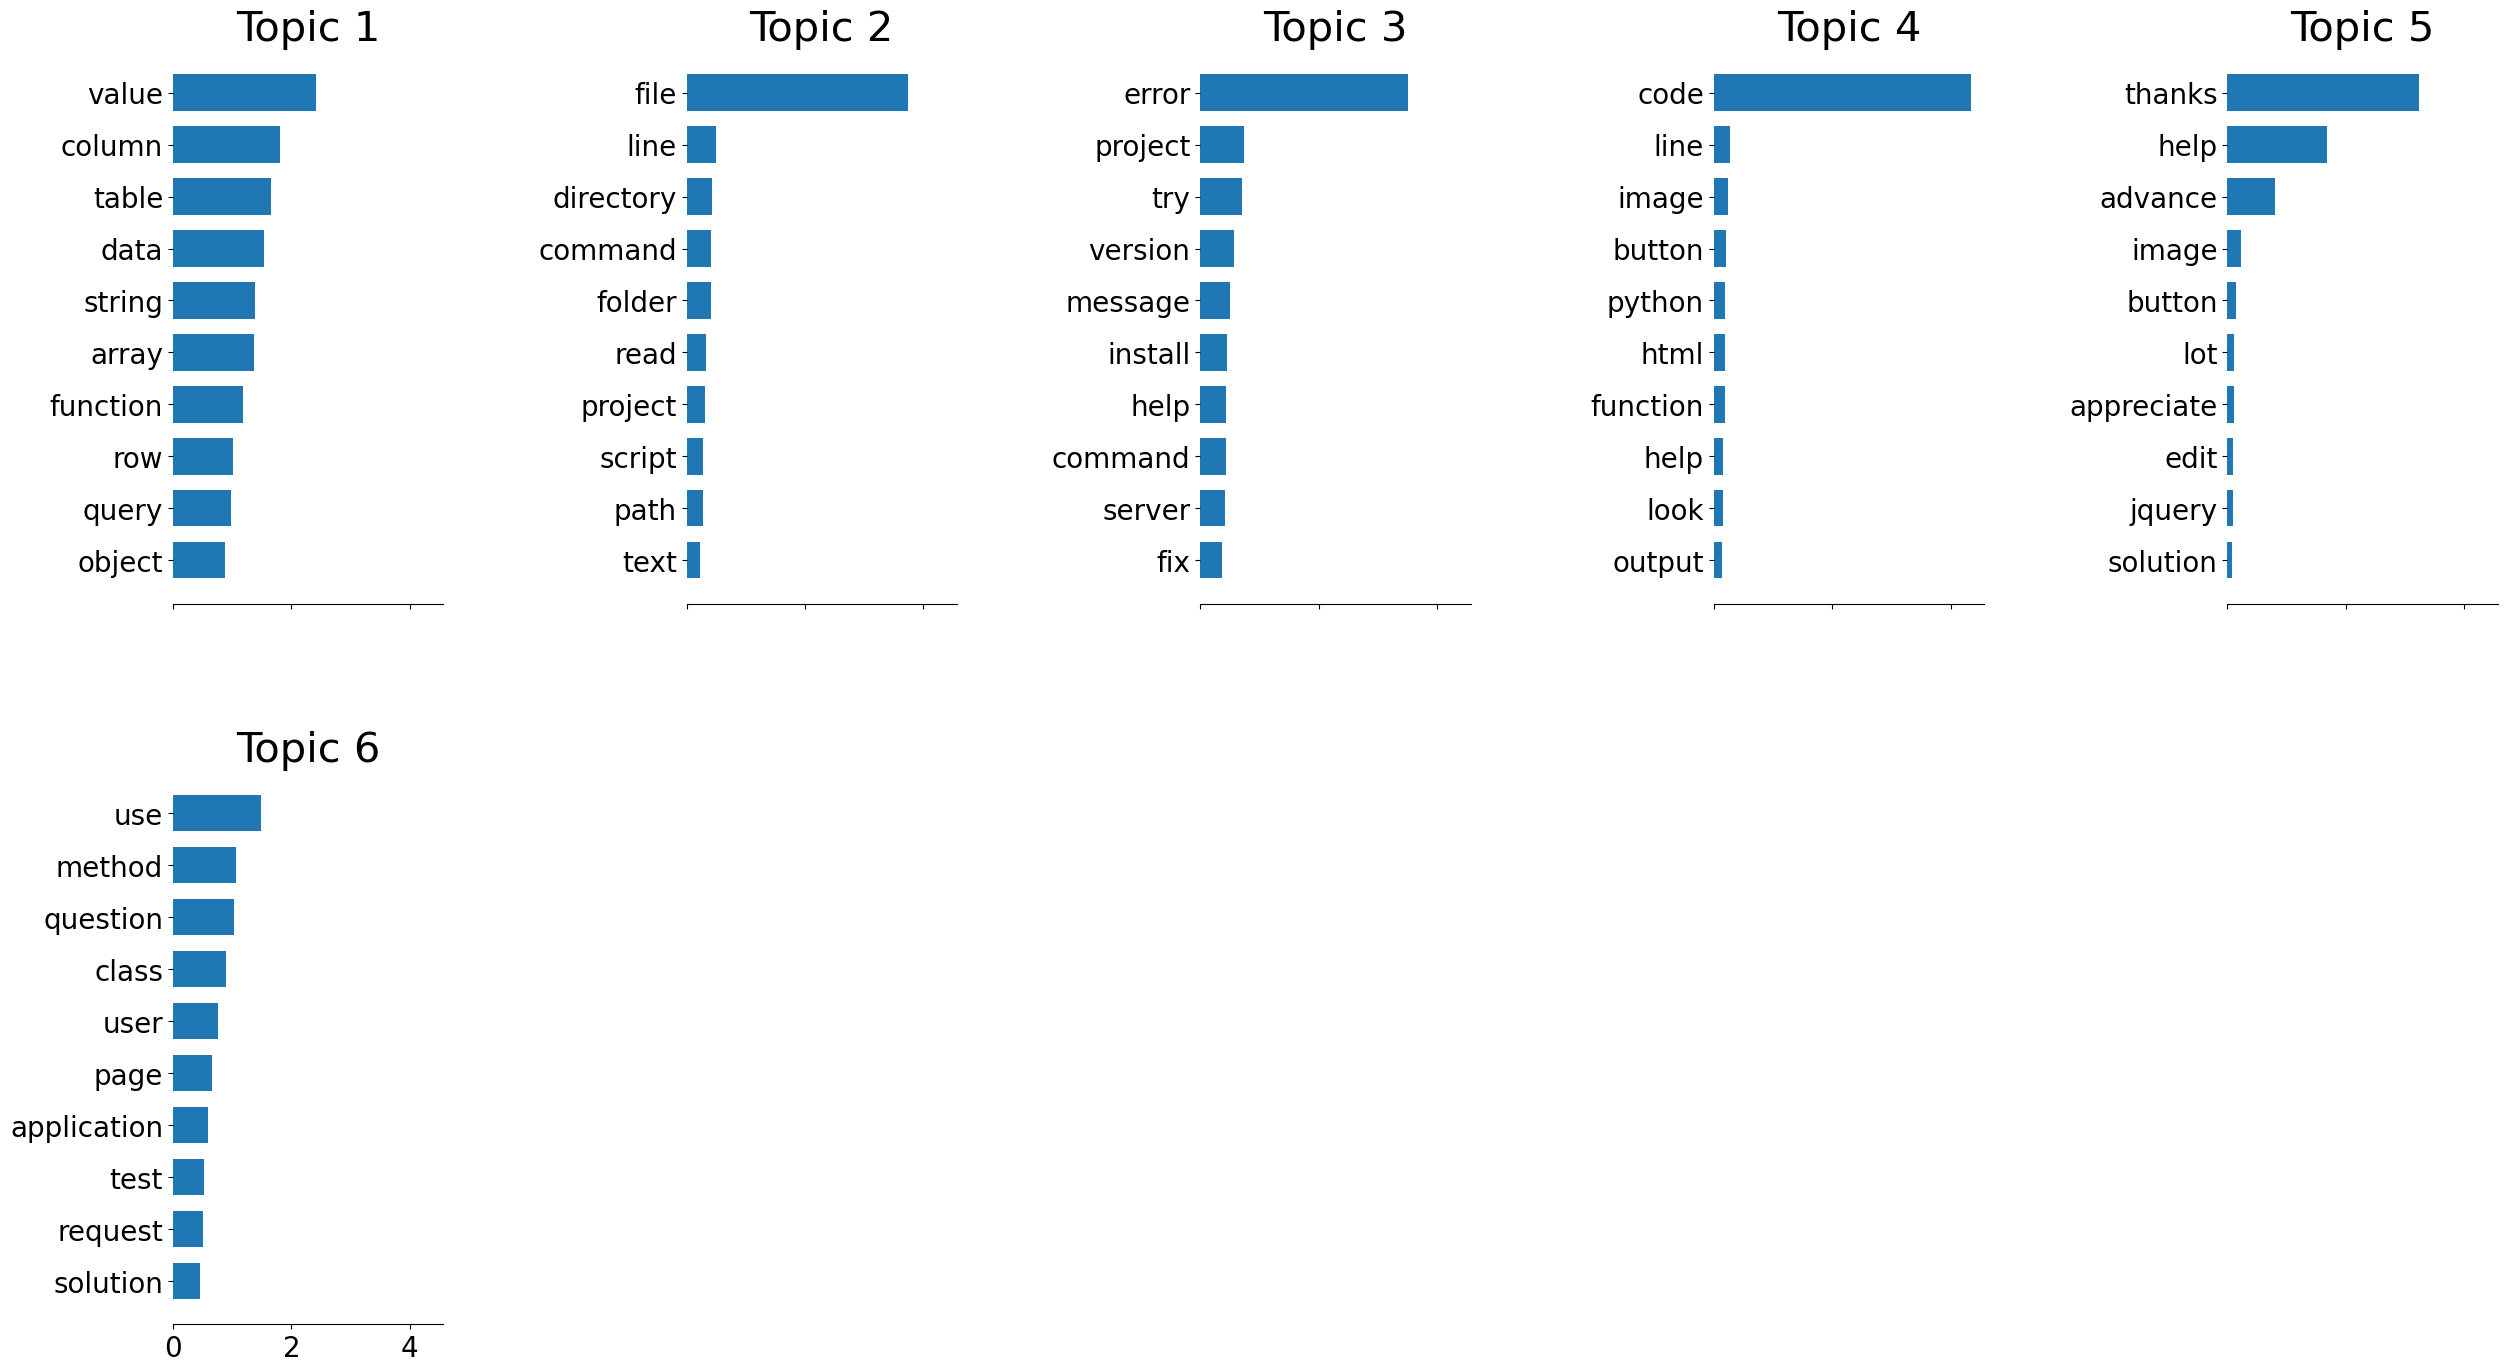

CPU times: total: 1.5 s
Wall time: 784 ms


In [ ]:
%%time
func.plot_top_words(nmf_model, vectorizer.get_feature_names_out(), n_top_words, 'Topics in NMF model', optimal_num_topics)

**Conclusion :**

La visualisation des mots clés pour chaque topic, tels que "use", "file", "code", "error", et "thanks", clarifie les thèmes dominants identifiés par le modèle NMF. Ces mots clés permettent au modèle de catégoriser plus efficacement les nouveaux documents, rendant les prédictions plus pertinentes et ciblées. Les visualisations montrent que le modèle est capable d'extraire des mots clés significatifs et de les associer à des topics spécifiques, ce qui améliore la compréhension et l'interprétation des thèmes sous-jacents dans le corpus de données.

#### Création des matrices de probabilités

Ensuite, je vais extraire et normaliser les probabilités des mots dans chaque topic (la matrice des topics words) du modèle NMF à partir de l'attribut `components_` :

In [ ]:
%%time
Mtopics_words_nmf = nmf_model.components_ 

CPU times: total: 0 ns
Wall time: 0 ns


#### La Matrice M_train_quest-topics NMF:

Je vais récupérer la matrice des topics des questions d'entraînement déterminés par NMF (obtenue en appliquant un `fit_transform` avec le modèle NMF sur les données d'entraînement de la colonne `train_df['combined_title_body']`), stockée dans `nmf_output`, et l'assigner à la variable `M_train_quest_topics_nmf` :

In [ ]:
%%time
M_train_quest_topics_nmf = nmf_output  # Sortie NMF pour les données d'entraînement
M_train_quest_topics_nmf.shape

CPU times: total: 0 ns
Wall time: 0 ns


(39876, 6)

#### La Matrice M_test_quest-topics NMF:

Je récupère aussi la matrice des topics des questions de test déterminés par NMF (obtenue en appliquant une prédiction avec le modèle NMF sur le bag-of-words des données de test de la colonne `test_df['combined_title_body']`), et l'assigner à la variable `M_test_quest_topics_nmf` :

In [ ]:
%%time
M_test_quest_topics_nmf = func.prediction(bow_test_combined, nmf_model) # Transformation des données de test
M_test_quest_topics_nmf.shape

CPU times: total: 1.44 s
Wall time: 259 ms


(9976, 6)

In [ ]:
# with open('Model/unsupervised/train_topics_nmf.pkl', 'wb') as file:
#     pickle.dump(M_train_quest_topics_nmf, file)

#### Calcul des probabilités de mots pour les questions Train et Test

On prend la matrice des topics des questions d'entraînement et le modèle NMF, puis on effectue **un produit matriciel** pour produire une matrice des mots spécifiques à chaque topic. Le résultat, assigné à `M_train_quest_words_nmf`, représente ainsi les mots clés filtrés en fonction de leur pertinence pour chaque topic identifié :

In [ ]:
%%time
M_train_quest_words_nmf = func.calculate_words(M_train_quest_topics_nmf, nmf_model)  # Multiplication matricielle pour les données d'entraînement
M_train_quest_words_nmf.shape

CPU times: total: 1.45 s
Wall time: 323 ms


(39876, 5000)

On prend aussi la matrice des topics des questions de test et le modèle NMF, puis on effectue **un produit matriciel** pour produire une matrice des mots spécifiques à chaque topic. Le résultat, assigné à `M_test_quest_words_nmf`, représente ainsi les mots clés filtrés en fonction de leur pertinence pour chaque topic identifié :

In [ ]:
%%time
M_test_quest_words_nmf = func.calculate_words(M_test_quest_topics_nmf, nmf_model) # Multiplication matricielle pour les données de test
M_test_quest_words_nmf.shape

CPU times: total: 391 ms
Wall time: 78.3 ms


(9976, 5000)

# Application d'un seuil pour ne garder que les principaux mots

On applique sur la matrice `M_test_quest_words_nmf` un seuil de `threshold=0.00001` pour mettre à 0 les fréquences des mots inférieures à ce seuil, ce qui permet de garder uniquement les mots avec les plus grandes probabilités. Le résultat, assigné à `M_test_quest_words_filtered_nmf`, est obtenu via la fonction `filter_words` :

In [ ]:
%%time
M_test_quest_words_filtered_nmf = func.filter_words(M_test_quest_words_nmf, threshold=0.00001)  # Filtrage des mots basés sur le seuil
M_test_quest_words_filtered_nmf.shape

CPU times: total: 688 ms
Wall time: 122 ms


(9976, 5000)

#### Création de DataFrames avec les mots clés proposés

Ensuite, je construis le DataFrame `df_keywords_test_nmf` en utilisant les noms des mots extraits par le vectoriseur et les mots filtrés de la matrice `M_test_quest_words_filtered_nmf`. Les noms des colonnes du DataFrame sont obtenus via `vectorizer.get_feature_names_out()` et les index sont alignés avec ceux de `test_df`. Le résultat est le DataFrame `df_keywords_test_nmf`, qui contient les mots clés pertinents pour chaque document de test :

In [ ]:
%%time
words = vectorizer.get_feature_names_out()
df_keywords_test_nmf = pd.DataFrame(M_test_quest_words_filtered_nmf, columns=words, index=test_df.index)

CPU times: total: 15.6 ms
Wall time: 2.51 ms


In [ ]:
df_keywords_test_nmf

,file,error,code,use,data,value,server,function,method,class,...,addendum,n2,inout,mq,quarter,esc,blame,speedup,collaborator,bytea
0,0.000000,0.000000,0.002042,0.011342,0.019874,0.026062,0.005363,0.009578,0.007246,0.005779,...,0.000015,0.000047,0.0,0.000025,0.000074,0.000000,0.000000,0.000011,0.000000,0.0
1,0.000000,0.084529,0.000000,0.002626,0.035670,0.049632,0.014010,0.013616,0.000000,0.000598,...,0.000012,0.000090,0.0,0.000000,0.000125,0.000016,0.000000,0.000000,0.000028,0.0
2,0.010290,0.028904,0.000000,0.066595,0.010464,0.003887,0.019061,0.021706,0.047953,0.038450,...,0.000061,0.000000,0.0,0.000159,0.000071,0.000000,0.000016,0.000071,0.000030,0.0
3,0.000000,0.172433,0.000000,0.092743,0.010444,0.000000,0.038435,0.031069,0.067228,0.054840,...,0.000081,0.000000,0.0,0.000232,0.000081,0.000000,0.000024,0.000100,0.000087,0.0
4,0.080316,0.035007,0.031354,0.010354,0.014251,0.015936,0.009728,0.008179,0.005132,0.004341,...,0.000030,0.000029,0.0,0.000040,0.000069,0.000000,0.000000,0.000000,0.000017,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000000,0.074179,0.009321,0.047296,0.064006,0.008768,0.020099,0.004188,0.003340,...,0.000020,0.000116,0.0,0.000064,0.000165,0.000021,0.000000,0.000000,0.000000,0.0
9996,0.092539,0.000000,0.004525,0.082627,0.021051,0.007891,0.025121,0.026988,0.057703,0.046022,...,0.000296,0.000015,0.0,0.000192,0.000116,0.000000,0.000020,0.000085,0.000025,0.0
9997,0.113159,0.019813,0.000000,0.003463,0.011806,0.003059,0.010164,0.001728,0.000000,0.000140,...,0.000360,0.000000,0.0,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.0
9998,0.042933,0.000000,0.001032,0.017845,0.002806,0.000000,0.005384,0.005366,0.012042,0.009604,...,0.000025,0.000000,0.0,0.000040,0.000027,0.000000,0.000000,0.000018,0.000000,0.0


On va utiliser ce DataFrame `df_keywords_test_nmf` pour créer une colonne `predicted_nmf` dans le DataFrame `test_df` :

In [ ]:
test_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags,predicted_lda
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '...","[code, error, use, method, file, class, help, ..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram...","[code, value, table, string, column, use, erro..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd...","[code, method, error, class, use, request, tes..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas...","[code, method, use, class, error, request, tes..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi...","[image, code, thanks, use, view, color, help, ..."


In [ ]:
%%time
test_df['predicted_nmf'] = df_keywords_test_nmf.apply(lambda row: row.nlargest(len(test_df.split_tags)).index.tolist(), axis=1)

CPU times: total: 8.05 s
Wall time: 8.28 s


In [ ]:
test_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags,predicted_lda,predicted_nmf
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '...","[code, error, use, method, file, class, help, ...","[value, column, table, data, string, array, ro..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram...","[code, value, table, string, column, use, erro...","[error, value, column, table, data, string, ar..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd...","[code, method, error, class, use, request, tes...","[use, method, question, class, error, test, pa..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas...","[code, method, use, class, error, request, tes...","[error, use, method, question, class, try, pro..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi...","[image, code, thanks, use, view, color, help, ...","[file, error, code, project, value, line, colu..."


### Approche semi-supervisée

Pour évaluer la similarité entre les topics des questions de test et ceux des questions d'entraînement, nous utilisons la mesure de similarité cosinus. Cette méthode compare les vecteurs de topics en calculant le cosinus de l'angle entre eux, ce qui permet de quantifier la ressemblance des distributions de topics entre les deux ensembles de questions. Nous appliquons cette méthode aux matrices de topics générées par les modèles LDA et NMF pour obtenir les matrices de similarité correspondantes :

In [ ]:
%%time
similarity_matrix_lda = func.calculate_similarity_matrix(M_test_quest_topics_lda, M_train_quest_topics_lda)  # Matrice de similarité pour LDA
similarity_matrix_lda.shape

CPU times: total: 2.08 s
Wall time: 371 ms


(9976, 39876)

In [ ]:
%%time
similarity_matrix_nmf = func.calculate_similarity_matrix(M_test_quest_topics_nmf, M_train_quest_topics_nmf)  # Matrice de similarité pour NMF
similarity_matrix_nmf.shape

CPU times: total: 2.3 s
Wall time: 350 ms


(9976, 39876)

#### Création de la liste du vocabulaire des mots les plus fréquents de corpus `df['split_tags'] `:

In [ ]:
# Convertir les chaînes de caractères en listes pour la colonne 'split_tags'
# Cette étape est nécessaire si 'split_tags' contient des listes de tags encodées en chaînes de caractères
df['split_tags'] = df['split_tags'].apply(ast.literal_eval)

In [ ]:
# Combiner tous les tags en une seule liste de corpus
corpus_tags = [tag for sublist in df['split_tags'] for tag in sublist]

# Afficher la fréquence de chaque tag dans le corpus
value_counts_tags = pd.Series(corpus_tags).value_counts()
print("Fréquence de chaque tag dans le corpus :\n\n",value_counts_tags)

Fréquence de chaque tag dans le corpus :

 python        8733
java          8023
android       6700
javascript    6641
c#            6204
              ... 
longest          1
gerrit           1
stdev            1
texture2d        1
qtoolbar         1
Length: 10795, dtype: int64


À partir des résultats de `value_counts` obtenus pour le corpus de tags `df['split_tags']`, je sélectionnerai les 200 mots les plus fréquents. Ces mots seront ensuite intégrés dans la liste `vocabulary_tags` :

In [ ]:
vocabulary_tags = list(value_counts_tags.head(200).index)
print(vocabulary_tags)

['python', 'java', 'android', 'javascript', 'c#', 'sql', 'spring', 'html', 'jquery', 'aspnet', 'php', 'ios', 'c++', 'server', 'css', 'mvc', 'google', 'linux', 'studio', 'windows', 'web', 'nodejs', 'database', 'json', 'mysql', 'django', 'string', 'visual', 'file', 'iphone', 'objective', 'arrays', 'ruby', 'laravel', 'http', 'angular', 'data', 'apache', 'image', 'reactjs', 'pandas', 'testing', 'api', 'selenium', 'bootstrap', 'amazon', 'git', 'services', 'boot', 'rails', 'swift', 'xcode', 'jpa', 'on', 'react', 'maven', 'ajax', 'hibernate', 'twitter', 'bash', 'eclipse', 'angularjs', 'postgresql', 'framework', 'typescript', 'rest', 'docker', 'ubuntu', 'chrome', 'macos', 'dataframe', 'numpy', 'xml', 'shell', 'ssl', 'date', 'core', 'unit', 'excel', 'datetime', 'gradle', 'spark', 'list', 'oracle', 'cocoa', 'entity', 'security', 'forms', 'command', 'performance', 'memory', 'ui', 'code', 'class', 'authentication', 'webdriver', 'layout', 'line', 'learning', 'flutter', 'variables', 'touch', 'interf

#### Création des vectoriseurs pour les tags:

In [ ]:
%%time
vectorizer_tags = TfidfVectorizer(vocabulary=vocabulary_tags)  # Vectoriseur pour les tags
# vectorizer_tags = TfidfVectorizer(max_features=5000)
X_tags = vectorizer_tags.fit_transform(train_df['split_tags'])  # Transformation des tags d'entraînement
tags_train = X_tags.toarray()  # Conversion en array numpy
tags_train.shape

CPU times: total: 234 ms
Wall time: 301 ms


(39876, 5000)

In [ ]:
# with open('Model/unsupervised/vectorizer_tags.pkl', 'wb') as file:
#     pickle.dump(vectorizer_tags, file)

In [ ]:
# np.savez('Model/unsupervised/tags_train.npz', tags_train=tags_train)

#### Extraire les Mots clés semi-supervisés pour LDA et NMF:

On prend la matrice des topics des questions de test et la matrice de similarité LDA, puis on effectue **une multiplication matricielle** pour produire une matrice des mots clés semi-supervisés. Le résultat, assigné à `keywords_test_semi_supervised_lda`, représente les mots clés filtrés en fonction de leur pertinence pour chaque topic identifié :

In [ ]:
%%time
keywords_test_semi_supervised_lda = np.dot(similarity_matrix_lda, tags_train)  # Mots clés semi-supervisés pour LDA
keywords_test_semi_supervised_lda.shape

CPU times: total: 1min 11s
Wall time: 10.7 s


(9976, 5000)

On prend la matrice des topics des questions de test et la matrice de similarité NMF, puis on effectue **une multiplication matricielle** pour produire une matrice des mots clés semi-supervisés. Le résultat, assigné à `keywords_test_semi_supervised_nmf`, représente les mots clés filtrés en fonction de leur pertinence pour chaque topic identifié :

In [ ]:
%%time
keywords_test_semi_supervised_nmf = np.dot(similarity_matrix_nmf, tags_train)  # Mots clés semi-supervisés pour NMF
keywords_test_semi_supervised_nmf.shape

CPU times: total: 1min 13s
Wall time: 11 s


(9976, 5000)

#### Création de DataFrames avec les mots clés proposés par les modèles LDA et NMF en semi-supervisé:

Ensuite, je construis les DataFrames `df_keywords_test_semi_supervised_lda` et `df_keywords_test_semi_supervised_nmf` en utilisant les noms des tags extraits par le vectoriseur et les mots filtrés des matrices `keywords_test_semi_supervised_lda` et `keywords_test_semi_supervised_nmf`. Les noms des colonnes des DataFrames sont obtenus via `vectorizer_tags.get_feature_names_out()` et les index sont alignés avec ceux de `test_df`. Le résultat est deux DataFrames, `df_keywords_test_semi_supervised_lda` et `df_keywords_test_semi_supervised_nmf`, qui contiennent les mots clés pertinents pour chaque document de test :

In [ ]:
%%time
tags = vectorizer_tags.get_feature_names_out()
df_keywords_test_semi_supervised_lda = pd.DataFrame(keywords_test_semi_supervised_lda, columns=tags, index=test_df.index)
df_keywords_test_semi_supervised_nmf = pd.DataFrame(keywords_test_semi_supervised_nmf, columns=tags, index=test_df.index)

CPU times: total: 0 ns
Wall time: 7.03 ms


In [ ]:
df_keywords_test_semi_supervised_lda

,python,java,android,javascript,c#,sql,spring,html,jquery,aspnet,...,ocx,protobuf,shopify,proxypass,html2pdf,cpuid,avplayerviewcontroller,justify,fillna,vetur
0,481.623434,560.115189,402.681380,689.474234,0.0,215.329206,513.487137,475.240376,514.157457,431.577607,...,0.326697,0.519386,1.072464,0.645488,0.232915,0.439921,0.428419,0.687954,0.360670,1.109968
1,680.648715,474.834639,240.781663,309.840432,0.0,800.358592,212.828985,170.781121,174.490965,167.897257,...,0.351137,0.801306,0.191576,0.240651,0.135275,0.430275,0.281369,0.211334,1.850381,0.427616
2,343.555452,532.604085,279.679062,397.274506,0.0,144.870370,599.545677,161.284208,207.061559,408.698612,...,0.124915,0.544056,0.738282,0.664800,0.132401,0.196642,0.274284,0.206177,0.231985,0.245316
3,358.097866,533.198778,310.457061,546.572303,0.0,150.277951,574.554231,319.083887,368.223716,434.072011,...,0.125537,0.521783,0.943299,0.640276,0.147728,0.199096,0.279572,0.426614,0.237009,0.613405
4,383.356634,258.711591,447.580019,248.114978,0.0,147.001158,126.677052,223.322045,172.591535,110.425084,...,0.146566,0.193463,0.223543,0.275064,0.674449,0.230443,0.719378,1.023807,0.269472,0.290457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,595.695554,622.601802,277.388279,424.162812,0.0,634.661560,520.599055,189.096893,226.263517,366.156108,...,0.122884,0.894762,0.570734,0.543018,0.131586,0.197777,0.276938,0.209989,1.427458,0.243826
9996,608.499186,349.450740,490.536496,276.470877,0.0,154.814518,145.625300,193.948645,151.426865,118.922043,...,0.883515,0.169681,0.198335,0.239618,0.489052,0.970414,0.561737,0.748994,0.248108,0.856100
9997,279.007482,356.979898,369.123531,198.079884,0.0,208.634178,268.545319,128.128712,99.710571,151.131391,...,0.102453,0.508093,0.386013,1.433181,0.605802,0.660454,1.872457,0.170323,0.191142,0.200435
9998,557.086353,603.207446,417.214727,583.517259,0.0,203.343285,556.333220,339.914278,376.299696,423.701323,...,0.567449,0.529105,0.905347,0.654797,0.198480,0.673005,0.384680,0.480485,0.325619,0.978564


In [ ]:
df_keywords_test_semi_supervised_nmf

,python,java,android,javascript,c#,sql,spring,html,jquery,aspnet,...,ocx,protobuf,shopify,proxypass,html2pdf,cpuid,avplayerviewcontroller,justify,fillna,vetur
0,555.133889,503.210886,484.600047,394.395073,0.0,313.575949,421.505891,213.546529,227.237268,279.367952,...,0.804170,0.554052,0.397407,1.260654,0.244764,0.664721,0.632644,0.261321,0.566749,0.398099
1,537.440423,376.672161,375.109638,329.103729,0.0,242.824585,257.668713,184.568028,197.477098,192.610406,...,0.550139,0.254262,0.017219,0.737415,0.124097,0.878935,0.093415,0.318552,0.339448,1.227606
2,564.655277,747.377803,666.286534,712.616001,0.0,290.868870,596.458993,522.674595,519.010172,455.666443,...,0.508951,1.063261,1.124594,1.129399,0.489859,1.087010,1.753224,0.822135,0.401003,0.448725
3,565.955558,660.193095,591.857073,668.181662,0.0,256.346752,482.287315,498.946748,498.123011,395.657385,...,0.323445,0.813168,0.824840,0.791342,0.398102,1.249189,1.319629,0.819537,0.281946,1.092281
4,678.042208,526.179427,463.741597,467.035883,0.0,354.572451,343.089952,310.339393,292.059157,267.129865,...,0.784674,0.804358,0.380887,0.628143,0.423895,1.040615,0.707776,0.979398,0.591096,0.835351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,566.956668,399.808902,360.111917,300.114875,0.0,422.239446,312.565768,135.985449,154.104988,208.810812,...,0.696718,0.337448,0.123631,1.031339,0.278455,0.522112,0.199876,0.164084,0.952899,0.380016
9996,508.925877,614.178270,567.339974,588.751582,0.0,274.932603,464.862526,443.574940,441.269683,342.293614,...,0.473725,0.915244,1.182646,0.732767,0.767591,0.679182,1.275548,0.834802,0.273143,0.309933
9997,265.851476,243.750891,245.932768,253.415261,0.0,134.860643,144.851091,204.619927,206.121372,105.395771,...,0.177100,0.338766,0.628056,0.039701,0.605208,0.203689,0.263325,0.497328,0.010909,0.377478
9998,514.197799,605.843502,535.442267,548.137349,0.0,231.089530,463.095703,403.626299,376.097717,345.355494,...,0.711543,1.126987,0.926475,0.781438,0.474178,0.888345,1.510049,1.041896,0.279207,0.135000


##### Création de la colonne `predicted_lda_semi_supervised` dans le DataFrame `test_df` :

On va utiliser ce DataFrame `df_keywords_test_semi_supervised_lda` pour créer une colonne `predicted_lda_semi_supervised` dans le DataFrame `test_df` :

In [ ]:
test_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags,predicted_lda,predicted_nmf
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '...","[code, error, use, method, file, class, help, ...","[value, column, table, data, string, array, ro..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram...","[code, value, table, string, column, use, erro...","[error, value, column, table, data, string, ar..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd...","[code, method, error, class, use, request, tes...","[use, method, question, class, error, test, pa..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas...","[code, method, use, class, error, request, tes...","[error, use, method, question, class, try, pro..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi...","[image, code, thanks, use, view, color, help, ...","[file, error, code, project, value, line, colu..."


In [ ]:
%%time
test_df['predicted_lda_semi_supervised'] = df_keywords_test_semi_supervised_lda.apply(lambda row: row.nlargest(len(test_df.split_tags.iloc[0])).index.tolist(), axis=1)

CPU times: total: 6.45 s
Wall time: 6.33 s


In [ ]:
test_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags,predicted_lda,predicted_nmf,predicted_lda_semi_supervised
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '...","[code, error, use, method, file, class, help, ...","[value, column, table, data, string, array, ro...","[javascript, java, jquery, spring, python, htm..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram...","[code, value, table, string, column, use, erro...","[error, value, column, table, data, string, ar...","[sql, python, java, server, javascript, string..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd...","[code, method, error, class, use, request, tes...","[use, method, question, class, error, test, pa...","[spring, java, aspnet, javascript, python, mvc..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas...","[code, method, use, class, error, request, tes...","[error, use, method, question, class, try, pro...","[spring, javascript, java, aspnet, jquery, pyt..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi...","[image, code, thanks, use, view, color, help, ...","[file, error, code, project, value, line, colu...","[android, python, ios, java, javascript, html,..."


##### Création de la colonne `predicted_nmf_semi_supervised` dans le DataFrame `test_df` :

On va utiliser ce DataFrame `df_keywords_test_semi_supervised_nmf` pour créer une colonne `predicted_nmf_semi_supervised` dans le DataFrame `test_df` :

In [ ]:
%%time
test_df['predicted_nmf_semi_supervised'] = df_keywords_test_semi_supervised_nmf.apply(lambda row: row.nlargest(len(test_df.split_tags.iloc[0])).index.tolist(), axis=1)

CPU times: total: 6.06 s
Wall time: 6.52 s


In [ ]:
test_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags,predicted_lda,predicted_nmf,predicted_lda_semi_supervised,predicted_nmf_semi_supervised
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '...","[code, error, use, method, file, class, help, ...","[value, column, table, data, string, array, ro...","[javascript, java, jquery, spring, python, htm...","[python, java, android, spring, javascript, sq..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram...","[code, value, table, string, column, use, erro...","[error, value, column, table, data, string, ar...","[sql, python, java, server, javascript, string...","[python, java, android, javascript, spring, sq..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd...","[code, method, error, class, use, request, tes...","[use, method, question, class, error, test, pa...","[spring, java, aspnet, javascript, python, mvc...","[java, javascript, android, spring, python, ht..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas...","[code, method, use, class, error, request, tes...","[error, use, method, question, class, try, pro...","[spring, javascript, java, aspnet, jquery, pyt...","[javascript, java, android, python, html, jque..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi...","[image, code, thanks, use, view, color, help, ...","[file, error, code, project, value, line, colu...","[android, python, ios, java, javascript, html,...","[python, java, javascript, android, sql, sprin..."


In [ ]:
test_df.to_csv("Data/stack_overflow_data_cleaned_test_predicted_tags_non_supervised.csv", index=False)

#### Calcul du taux de couverture par rapport aux tags réels:

#### Taux de couverture pour le modèle LDA:

In [ ]:
average_coverage_lda = func.coverage_rate(test_df, 'split_tags', 'predicted_lda')
print(f"Taux de couverture moyen pour LDA: {average_coverage_lda:.2f}")

Taux de couverture moyen pour LDA: 0.55


#### Taux de couverture pour le modèle NMF:

In [ ]:
average_coverage_nmf = func.coverage_rate(test_df, 'split_tags', 'predicted_nmf')
print(f"Taux de couverture moyen pour NMF: {average_coverage_nmf:.2f}")

Taux de couverture moyen pour NMF: 0.55


#### Taux de couverture pour le modèle lda_semi_supervised:

In [ ]:
average_coverage_lda_semi_supervised = func.coverage_rate(test_df, 'split_tags', 'predicted_lda_semi_supervised')
print(f"Taux de couverture moyen pour LDA semi-supervisé: {average_coverage_lda_semi_supervised:.2f}")

Taux de couverture moyen pour LDA semi-supervisé: 0.00


#### Taux de couverture pour le modèle nmf_semi_supervised:

In [ ]:
average_coverage_nmf_semi_supervised = func.coverage_rate(test_df, 'split_tags', 'predicted_nmf_semi_supervised')
print(f"Taux de couverture moyen pour NMF semi-supervisé: {average_coverage_nmf_semi_supervised:.2f}")

Taux de couverture moyen pour NMF semi-supervisé: 0.00


#### Visualisation de la distribution des topics

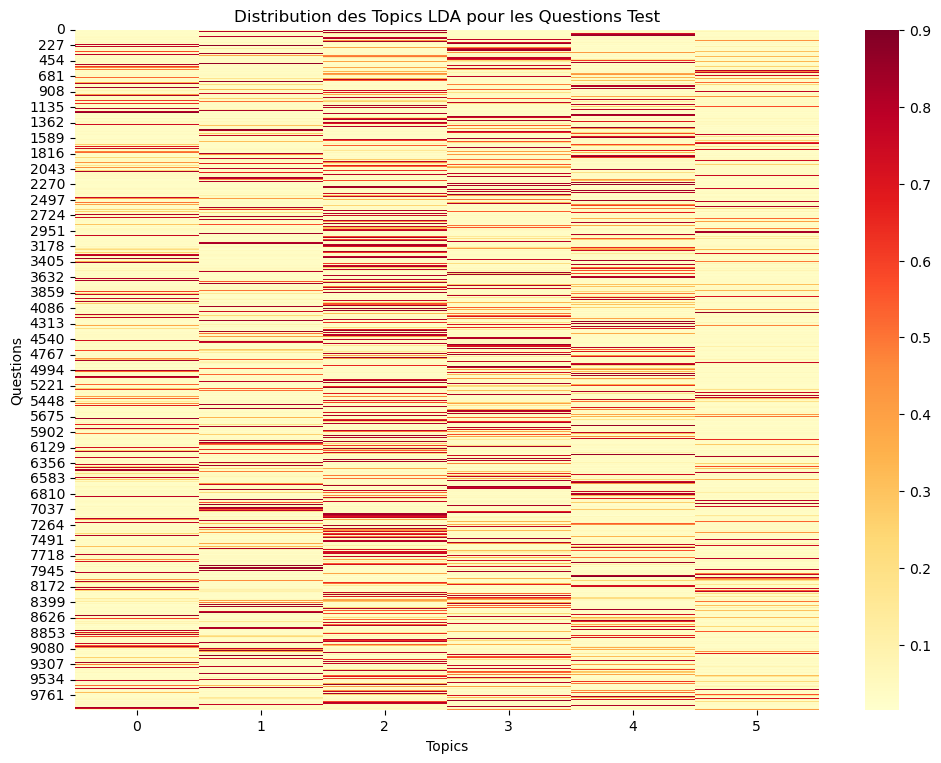

In [ ]:
# Créer la heatmap pour les topics LDA
func.plot_heatmap(M_test_quest_topics_lda, 'Distribution des Topics LDA pour les Questions Test')

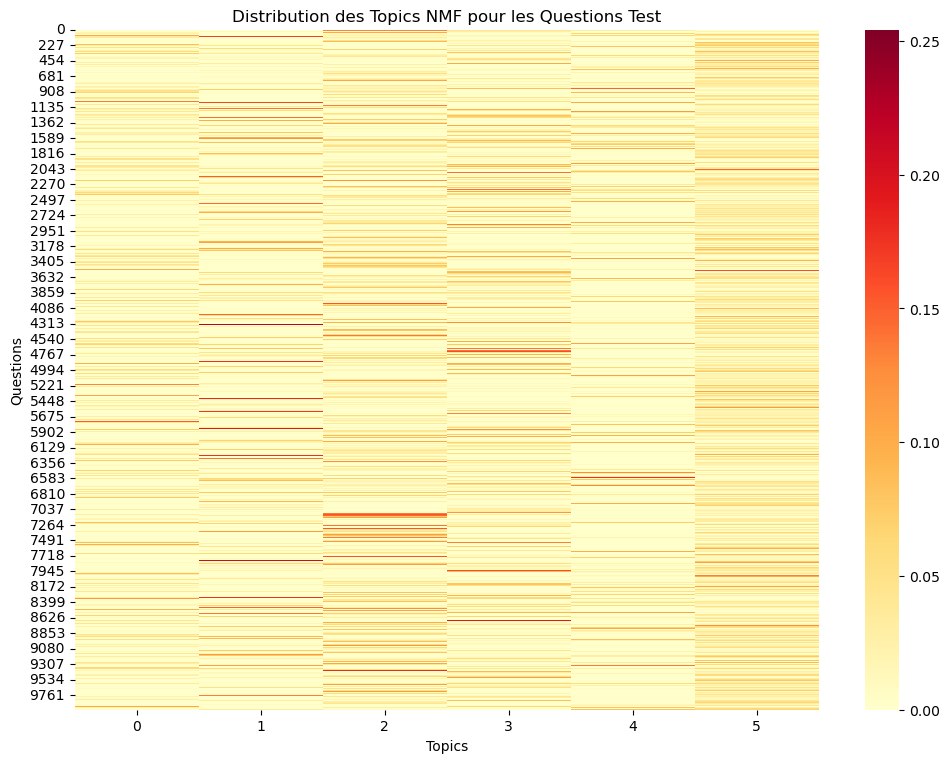

In [ ]:
# Créer la heatmap pour les topics NMF
func.plot_heatmap(M_test_quest_topics_nmf, 'Distribution des Topics NMF pour les Questions Test')

#### Test de visu sur quelques questions

In [ ]:
sample_indices = np.random.choice(test_df.index, 5, replace=False)  # Sélection aléatoire de quelques indices

for i in sample_indices:
    print(f"Question: {test_df.loc[i, 'combined_title_body']}")
    print(f"Tags réels: {test_df.loc[i, 'split_tags']}")
    print(f"Mots clés proposés (LDA): {df_keywords_test_lda.loc[i].nlargest(5).index.tolist()}")  # type: ignore # Mots clés proposés par LDA
    print(f"Mots clés proposés (NMF): {df_keywords_test_nmf.loc[i].nlargest(5).index.tolist()}")  # Mots clés proposés par NMF
    print(f"Mots clés semi-supervisés (LDA): {df_keywords_test_semi_supervised_lda.loc[i].nlargest(5).index.tolist()}")  # Mots clés semi-supervisés par LDA
    print(f"Mots clés semi-supervisés (NMF): {df_keywords_test_semi_supervised_nmf.loc[i].nlargest(5).index.tolist()}")  # Mots clés semi-supervisés par NMF
    print("--------------------------------------------------")

Question: list repository yum python api search repostiries delete yum python api fedora ton website found manage package found handle repository python yum api result simmilar etc
Tags réels: ['python', 'repository', 'package', 'fedora', 'yum']
Mots clés proposés (LDA): ['file', 'error', 'server', 'code', 'app']
Mots clés proposés (NMF): ['use', 'error', 'method', 'question', 'class']
Mots clés semi-supervisés (LDA): ['android', 'java', 'python', 'spring', 'ios']
Mots clés semi-supervisés (NMF): ['java', 'javascript', 'python', 'android', 'spring']
--------------------------------------------------
Question: c++ include standard library source file bit moment planning include multiple source header file time project right approach include string header source file stdafxhpp header c++ include maincpp stringlib1h stringlib1cpp stringlib2h stringlib2cpp
Tags réels: ['c++', 'include', 'header', 'files', 'standard', 'library', 'precompiled', 'headers']
Mots clés proposés (LDA): ['file', '

### Création d'un code à tester avant de l'implémenter dans la future API :

#### Charger les modèles et les matrices:

In [ ]:
# with open('Model/unsupervised/lda_model.pkl', 'rb') as file:
#     lda_model = pickle.load(file)
    
# with open('Model/unsupervised/nmf_model.pkl', 'rb') as file:
#     nmf_model = pickle.load(file)

# with open('Model/unsupervised/vectorizer.pkl', 'rb') as file:
#     vectorizer= pickle.load(file)
    
# with open('Model/unsupervised/vectorizer_tags.pkl', 'rb') as file:
#     vectorizer_tags = pickle.load(file)
    

# with open('Model/unsupervised/train_topics_lda.pkl', 'rb') as file:
#     train_topics_lda = pickle.load(file)
    
# with open('Model/unsupervised/train_topics_nmf.pkl', 'rb') as file:
#     train_topics_nmf = pickle.load(file)
    

# # Charger la matrice des tags depuis le fichier compressé NPZ
# file_path_tags = 'Model/unsupervised/tags_train.npz'
# with np.load(file_path_tags) as data:
#     tags_train = data['tags_train']

#### Tester le code:

#### library :

In [ ]:
# exemple de texte
texte = '''<p>How do I:</p>
<ol>
<li><p>Create a local branch from another branch (via <code>git branch</code> or <code>git checkout -b</code>).</p>
</li>
<li><p>Push the local branch
to the remote repository (i.e. publish), but make it
trackable so that <code>git pull</code> and <code>git push</code> will work.</p>
</li>
</ol>'''



print(texte)

<p>How do I:</p>
<ol>
<li><p>Create a local branch from another branch (via <code>git branch</code> or <code>git checkout -b</code>).</p>
</li>
<li><p>Push the local branch
to the remote repository (i.e. publish), but make it
trackable so that <code>git pull</code> and <code>git push</code> will work.</p>
</li>
</ol>


In [ ]:
# Exemple d'utilisation directe
user_input = texte

if user_input:
    # Nettoyage et tokenisation du texte d'entrée
    cleaned_html_input = func_exploratoire.clean_html(user_input)
    cleaned_input = func_exploratoire.process_clean_text(cleaned_html_input)
    
    predicted_keywords_lda, predicted_semi_supervised_keywords_lda, predicted_keywords_nmf, predicted_semi_supervised_keywords_nmf  = func.predict_keywords(cleaned_input, lda_model, nmf_model, vectorizer, M_train_quest_topics_lda, M_train_quest_topics_nmf, tags_train, vectorizer_tags)
    
    print("---------------------------------------")
    print("le texte nettoyé:", cleaned_input)
    print("---------------------------------------")
    print('Mots-clés prédits avec LDA model:')
    print(predicted_keywords_lda)
    print('Mots-clés semi-supervisés prédits LDA:')
    print(predicted_semi_supervised_keywords_lda)
    print("---------------------------------------")
    print('Mots-clés prédits avec NMF model:')
    print(predicted_keywords_nmf)
    print('Mots-clés semi-supervisés prédits NMF:')
    print(predicted_semi_supervised_keywords_nmf)
else:
    print("Veuillez entrer du texte pour la prédiction.")


---------------------------------------
le texte nettoyé: create branch branch push branch remote repository ie publish work
---------------------------------------
Mots-clés prédits avec LDA model:
['file', 'error', 'server', 'code', 'app']
Mots-clés semi-supervisés prédits LDA:
['android', 'java', 'python', 'spring', 'sql']
---------------------------------------
Mots-clés prédits avec NMF model:
['use', 'method', 'question', 'file', 'class']
Mots-clés semi-supervisés prédits NMF:
['java', 'javascript', 'android', 'spring', 'python']
